### Imports

In [8]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

## Tempo medio de cada modelo por fontes

In [9]:
from pathlib import Path
import glob
import pandas as pd

log_file = glob.glob(f'logs_[14]_thread/*.jsonl', recursive=True)

total_logs = pd.DataFrame()

for logs in log_file:
    partial_logs = pd.read_json(logs, lines=True)
    
    # Assign 'font' column based on the 'file' column
    def get_font(file_path):
        path = Path(file_path)
        if len(path.parts) == 0:
            return ''
        if path.parts[0] == 'data':
            return 'data'
        elif len(path.parts) > 1:
            return path.parts[1]
        else:
            return ''
    partial_logs['font'] = partial_logs['file'].apply(get_font)
    
    if 'logs_1_thread' in logs:
        partial_logs['thread'] = 1
    elif 'logs_4_thread' in logs:
        partial_logs['thread'] = 4
    total_logs = pd.concat([total_logs, partial_logs], ignore_index=True)
        
display(total_logs.head())

,model,mode,file,duration_seconds,timestamp,content,analysis,font,thread
0,deepseek-r1:14b (think),inference,,8.205244,2025-06-28 12:29:00,{},"<think>\nOkay, so I'm trying to figure out how...",,1
1,deepseek-r1:14b (think),inference,data/attack/20250606_143915.jsonl,4.405914,2025-06-28 12:29:05,"{""process"":""{'name': 'powershell.exe'}"",""winlo...","<think>\nAlright, I'm looking at this batch of...",data,1
2,deepseek-r1:14b (think),inference,data/attack/20250606_143915.jsonl,2.814817,2025-06-28 12:29:07,"{""process"":""{'name': 'svchost.exe'}"",""winlog"":...","<think>\nAlright, I'm looking at this batch of...",data,1
3,deepseek-r1:14b (think),inference,data/attack/20250606_143915.jsonl,6.850665,2025-06-28 12:29:14,"{""process"":""{'name': 'svchost.exe'}"",""winlog"":...","<think>\nAlright, let's try to figure out if t...",data,1
4,deepseek-r1:14b (think),inference,data/attack/20250606_143915.jsonl,6.239188,2025-06-28 12:29:21,"{""process"":""{'name': 'whoami.exe', 'command_li...","<think>\nAlright, let's try to figure out whet...",data,1


In [10]:
total_logs = total_logs[total_logs['content'] != '{}']
total_logs = total_logs[total_logs['duration_seconds'] < 120]

principal_models = ['deepseek-r1:14b (no_think)', 'deepseek-r1:14b (think)','gemma3:12b', 'llama3.1', 'mistral-nemo', 'phi4', 'qwen3:14b (think)', 'qwen3:14b (no_think)']

df_principal = total_logs[total_logs['model'].isin(principal_models)].copy()
df_filtering = total_logs[~total_logs['model'].isin(principal_models)].copy()

display(df_principal.groupby(['model', 'thread', 'font']).mean('duration_seconds').sort_values(by='duration_seconds'))
display(df_filtering.groupby(['model']).mean('duration_seconds'))

# Para o df_principal (com múltiplos níveis de groupby)
df_principal.groupby(['model', 'thread', 'font']) \
    .mean(numeric_only=True) \
    .reset_index() \
    .sort_values(by='duration_seconds') \
    .to_csv('results/time_principal_models.csv', index=False, decimal=',', sep=';')

# Para o df_filtering (apenas model)
df_filtering.groupby(['model']) \
    .mean(numeric_only=True) \
    .reset_index() \
    .to_csv('results/time_filtering_models.csv', index=False, decimal=',', sep=';')

duration_seconds
model             thread font                            
llama3.1          4      tinyllama_1.1b          0.819561
                         phi4-mini               0.830114
                         llama3.2_3b             0.847957
                         data                    0.866970
                         gemma3_4b               0.867534
...                                                   ...
qwen3:14b (think) 4      llama3.2_3b             9.667083
                         phi4-mini               9.762276
                         tinyllama_1.1b          9.792846
                         gemma3_4b              10.022462
                         data                   10.053197

[75 rows x 1 columns]

,duration_seconds,thread
model,,
gemma3:4b,0.866387,1.017106
llama3.2:3b,0.050508,4.000000
phi4-mini,0.809828,4.000000
tinyllama:1.1b,0.353052,4.000000


## Redução de linhas por modelo

In [11]:
from pathlib import Path

# COUNT LINES IN RAW FILES

raw_files = glob.glob('../../src/data/**/*.jsonl')

lines_count = pd.DataFrame()
for file in raw_files:
    logs = pd.read_json(file, lines=True)
    lines_count = pd.concat([lines_count, pd.DataFrame({'file': [Path(file).name], 'lines': [len(logs)]})], ignore_index=True)

In [12]:

# COUNT LINES IN FILTERING MODE FILES

raw_files = glob.glob('../filtering/**/**/*.jsonl')

logs_filtering = pd.DataFrame()

lines_count_filtering = pd.DataFrame()
for file in raw_files:
    logs = pd.read_json(file, lines=True)
    path = Path(file)
    lines_count_filtering = pd.concat([lines_count_filtering, pd.DataFrame({'model': [path.parts[2]], 'file': [path.name], 'lines': [len(logs)]})], ignore_index=True)

In [13]:
diff_logs = lines_count_filtering.merge(lines_count, on='file', how='outer', suffixes=('_filtering_mode', '_total'))
diff_logs['diff'] = diff_logs['lines_filtering_mode'] - diff_logs['lines_total']

diff_logs = diff_logs.drop(columns=['file'])

display(diff_logs.groupby('model').sum().sort_values(by='diff', ascending=False))
diff_logs.groupby('model').sum().sort_values(by='diff', ascending=False).to_csv('results/lines_per_model.csv', index=True, decimal=',', sep=';')

,lines_filtering_mode,lines_total,diff
model,,,
gemma3_4b,6737,6812,-75
phi4-mini,4905,6812,-1907
tinyllama_1.1b,3312,6812,-3500
llama3.2_3b,3252,6812,-3560


## Precisão dos modelos por fontes

### Inferências

In [14]:
import pandas as pd
import json
import glob
import re
from pathlib import Path

def extract_analysis_data(analysis_str):
    match = re.search(r"```json\s*(\{.*?\})\s*```", analysis_str, re.DOTALL)
    if not match:
        match = re.search(r"\{[^{}]*\"CLASSIFICATION\"[^{}]*\}", analysis_str, re.DOTALL)
    if match:
        try:
            return json.loads(match.group(1 if '```' in match.group(0) else 0))
        except json.JSONDecodeError:
            return None
    return None

all_data = pd.DataFrame()

for test in range(12):
    files = glob.glob(f'{test}/inference/**/*.jsonl', recursive=True)
    print(f"Test {test}: Encontrados {len(files)} arquivos JSONL.")
    
    # {test}/inference/{model}/{data|filtering}/{font}/{type}/data.jsonl
    for file_path in files:
        path = Path(file_path)
        model = path.parts[2]
        if(path.parts[3] == "data"):
            font = path.parts[3]
            type = path.parts[4]
        else:
            font = path.parts[4]
            type = path.parts[5]
        
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                try:
                    record = json.loads(line)
                    analysis_data = extract_analysis_data(record.get('analysis', ''))

                    all_data = pd.concat([all_data, pd.DataFrame([{
                        'model': model,
                        'type': type,
                        'font': font,
                        'source_file': record.get('file', ''),
                        'classification': analysis_data.get('CLASSIFICATION', "NOT INTERESTING") if analysis_data else "NOT INTERESTING",
                        'confidence': analysis_data.get('CONFIDENCE', 0) if analysis_data else 0,
                        'test': test
                    }])], ignore_index=True)

                except Exception as e:
                    print(f"Erro ao processar linha do arquivo {file_path}: {str(e)}")

print("-----------------------------------")
print(f"Total de registros processados: {len(all_data)}")
print("\nPrimeiros registros:")
display(all_data)
all_data.to_csv("results/classifications.csv", index=False)


Test 0: Encontrados 2399 arquivos JSONL.
Test 1: Encontrados 2400 arquivos JSONL.
Test 2: Encontrados 2400 arquivos JSONL.
Test 3: Encontrados 2399 arquivos JSONL.
Test 4: Encontrados 2400 arquivos JSONL.
Test 5: Encontrados 2400 arquivos JSONL.
Test 6: Encontrados 2400 arquivos JSONL.
Test 7: Encontrados 2400 arquivos JSONL.
Test 8: Encontrados 2400 arquivos JSONL.
Test 9: Encontrados 2400 arquivos JSONL.
Test 10: Encontrados 2400 arquivos JSONL.
Test 11: Encontrados 2399 arquivos JSONL.
-----------------------------------
Total de registros processados: 128337

Primeiros registros:


,model,type,font,source_file,classification,confidence,test
0,deepseek-r1_14b,attack,data,data/attack/20250411_175749.jsonl,INTERESTING,0.9,0
1,deepseek-r1_14b,attack,data,data/attack/20250411_175749.jsonl,INTERESTING,0.85,0
2,deepseek-r1_14b,attack,data,data/attack/20250411_175749.jsonl,INTERESTING,0.8,0
3,deepseek-r1_14b,attack,data,data/attack/20250411_175806.jsonl,INTERESTING,0.9,0
4,deepseek-r1_14b,attack,data,data/attack/20250411_175826.jsonl,INTERESTING,0.85,0
...,...,...,...,...,...,...,...
128332,qwen3_14b_think,safe,tinyllama_1.1b,filtering/tinyllama_1.1b/safe/safe_20250505_19...,NOT INTERESTING,0.75,11
128333,qwen3_14b_think,safe,tinyllama_1.1b,filtering/tinyllama_1.1b/safe/safe_20250505_19...,NOT INTERESTING,0.85,11
128334,qwen3_14b_think,safe,tinyllama_1.1b,filtering/tinyllama_1.1b/safe/safe_20250505_20...,INTERESTING,0.75,11
128335,qwen3_14b_think,safe,tinyllama_1.1b,filtering/tinyllama_1.1b/safe/safe_20250505_20...,NOT INTERESTING,0.85,11


### Métricas

### Gerando inferências concretas

In [15]:
import pandas as pd

def process_group(group):
    if group.empty:
        return pd.DataFrame()
    
    model = group['model'].iloc[0]
    source_file = group['source_file'].iloc[0]
    type_ = group['type'].iloc[0]
    font = group['font'].iloc[0]
    test = group['test'].iloc[0]

    # Contar ocorrências de cada classificação
    class_counts = group['classification'].value_counts()
    max_count = class_counts.max()
    
    # Identificar classes com contagem máxima (podem ser múltiplas em caso de empate)
    top_classes = class_counts[class_counts == max_count].index.tolist()
    
    # Critério de desempate: priorizar 'INTERESTING'
    if len(top_classes) > 1 and 'INTERESTING' in top_classes:
        majority_class = 'INTERESTING'
    else:
        majority_class = class_counts.idxmax()

    consolidated = pd.DataFrame({
        'model': [model],
        'font': [font],
        'source_file': [source_file],
        'type': [type_],
        'classification': [majority_class],
        'confidence': [group['confidence'].mean()],
        'test': [test]
    })
    
    return consolidated

df = pd.read_csv('results/classifications.csv')
df['confidence'] = pd.to_numeric(df['confidence'], errors='coerce')
df = df.dropna(subset=['confidence'])

processed = (
    df.groupby(['model', 'test', 'source_file'], group_keys=False)
    .apply(process_group)
    .reset_index(drop=True)
)

# Salvar resultado
final_df = processed[['model', 'font', 'source_file', 'type', 'classification', 'confidence', 'test']]
final_df.to_csv('results/consolidated_classifications.csv', index=False)


C:\Users\lucas\AppData\Local\Temp\ipykernel_10124\700540396.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(process_group)


## Comitê

#### Voto Majoritário

In [16]:
# Generate all combinations of models
import itertools
df = pd.read_csv('results/consolidated_classifications.csv')

models = df['model'].unique()

comb_2 = list(itertools.combinations(models, 2))
comb_3 = list(itertools.combinations(models, 3))

In [17]:
import pandas as pd

# 1) Leitura dos dados
df = pd.read_csv("results/consolidated_classifications.csv")

# 2) Resultado acumulado
results_vote_majority = pd.DataFrame()

# 3) Loop pelas combinações (agora como lista de tuplas)
for model_1, model_2, model_3 in comb_3:
    committee_models = [model_1, model_2, model_3]

    # Filtra somente os dados dos modelos da combinação
    df_comm = df[df["model"].isin(committee_models)]
    if df_comm.empty:
        continue

    # Voto majoritário por test + source_file
    vote = (
        df_comm
        .groupby(["test", "source_file"])["classification"]
        .agg(lambda x: x.value_counts().idxmax())
    )

    # Metadados auxiliares
    meta = (
        df_comm
        .groupby(["test", "source_file"])
        .agg({
            "font": "first",
            "type": "first"
        })
    )

    # Cria DataFrame de saída para essa combinação
    vote_df = pd.DataFrame({
        "vote": "majority_vote",
        "model_1": model_1,
        "model_2": model_2,
        "model_3": model_3,
        "test": meta.index.get_level_values("test"),
        "font": meta["font"].values,
        "source_file": meta.index.get_level_values("source_file"),
        "type": meta["type"].values,
        "classification": vote.values
    })

    # Adiciona ao acumulador
    results_vote_majority = pd.concat([results_vote_majority, vote_df], ignore_index=True)

# 4) Salva o resultado final
results_vote_majority.to_csv("results/consolidated_classifications_with_vote.csv", index=False, encoding="utf-8")


#### Votação Ponderada por Confiança

In [18]:
import pandas as pd

def weighted_vote_classification(group: pd.DataFrame) -> str:
    """
    Retorna a classificação com maior soma de confiança no grupo.
    """
    sums = group.groupby("classification")["confidence"].sum()
    return sums.idxmax()

INPUT_CSV_CLASSIFICATIONS = "results/consolidated_classifications.csv"
OUTPUT_CSV_VOTES          = "results/consolidated_classifications_with_vote.csv"

# 1) Carrega as inferências originais (para gerar os votos ponderados)
df = pd.read_csv(INPUT_CSV_CLASSIFICATIONS)
df["confidence"] = pd.to_numeric(df["confidence"], errors="coerce")
df = df.dropna(subset=["confidence"])

# 2) Carrega o CSV que já tem os votos majoritários
df_existing_votes = pd.read_csv(OUTPUT_CSV_VOTES)

# 3) Acumulador dos novos votos ponderados
results_weighted = pd.DataFrame()

# 4) Função para processar cada comitê
def process_combination(models, is_comb_3=True):
    df_comm = df[df["model"].isin(models)].copy()
    if df_comm.empty:
        return pd.DataFrame()

    vote = (
        df_comm
        .groupby(["test", "source_file"], group_keys=False)
        .apply(weighted_vote_classification)
        .rename("classification")
    )

    meta = (
        df_comm
        .groupby(["test", "source_file"])
        .agg({
            "font": "first",
            "type": "first"
        })
    )

    model_1 = models[0]
    model_2 = models[1]
    model_3 = models[2] if is_comb_3 else ""

    result = pd.DataFrame({
        "model_1": model_1,
        "model_2": model_2,
        "model_3": model_3,
        "test": meta.index.get_level_values("test"),
        "font": meta["font"].values,
        "source_file": meta.index.get_level_values("source_file"),
        "type": meta["type"].values,
        "classification": vote.values,
        "vote": "weighted_vote"  # marca como ponderado
    })

    return result

# 5) Processa todas as combinações de 3 modelos
for comb in comb_3:
    result_df = process_combination(comb, is_comb_3=True)
    results_weighted = pd.concat([results_weighted, result_df], ignore_index=True)

# 6) Processa todas as combinações de 2 modelos
for comb in comb_2:
    result_df = process_combination(comb, is_comb_3=False)
    results_weighted = pd.concat([results_weighted, result_df], ignore_index=True)

# 7) Concatena os votos ponderados com os já existentes (ex: votos majoritários)
df_final = pd.concat([df_existing_votes, results_weighted], ignore_index=True)

# 8) Salva no mesmo arquivo
df_final.to_csv(OUTPUT_CSV_VOTES, index=False, encoding="utf-8")


C:\Users\lucas\AppData\Local\Temp\ipykernel_10124\929003081.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_vote_classification)
C:\Users\lucas\AppData\Local\Temp\ipykernel_10124\929003081.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(weighted_vote_classification)
C:\Users\lucas\AppData\Local\Temp\ipykernel_10124\929003081.py:33: DeprecationWarning: DataFrameGroupBy.apply 

#### Seleção Dinâmica de Modelo

In [19]:
import pandas as pd

INPUT_CSV_CLASSIFICATIONS = "results/consolidated_classifications.csv"
OUTPUT_CSV_VOTES          = "results/consolidated_classifications_with_vote.csv"

# 1) Carrega as inferências
df = pd.read_csv(INPUT_CSV_CLASSIFICATIONS)
df["confidence"] = pd.to_numeric(df["confidence"], errors="coerce")
df = df.dropna(subset=["confidence"])

# 2) Carrega votos já existentes (voto majoritário e ponderado)
df_existing_votes = pd.read_csv(OUTPUT_CSV_VOTES)

# 3) Acumulador dos novos votos por seleção dinâmica
results_dynamic = pd.DataFrame()

# 4) Função para processar cada comitê
def process_combination_dynamic(models, is_comb_3=True):
    df_comm = df[df["model"].isin(models)].copy()
    if df_comm.empty:
        return pd.DataFrame()

    # Ordena por confiança e pega o primeiro de cada (test, source_file)
    df_selected = (
        df_comm
        .sort_values(["test", "source_file", "confidence"], ascending=[True, True, False])
        .groupby(["test", "source_file"], as_index=False)
        .first()
        .assign(vote="dynamic_selection")
    )

    # Adiciona colunas de identificação do comitê
    df_selected["model_1"] = models[0]
    df_selected["model_2"] = models[1]
    df_selected["model_3"] = models[2] if is_comb_3 else ""

    return df_selected[[
        "model_1", "model_2", "model_3", "test",
        "font", "source_file", "type", "classification", "vote"
    ]]

# 5) Processa todas as combinações de 3 modelos
for comb in comb_3:
    df_result = process_combination_dynamic(comb, is_comb_3=True)
    results_dynamic = pd.concat([results_dynamic, df_result], ignore_index=True)

# 6) Processa todas as combinações de 2 modelos
for comb in comb_2:
    df_result = process_combination_dynamic(comb, is_comb_3=False)
    results_dynamic = pd.concat([results_dynamic, df_result], ignore_index=True)

# 7) Junta com os votos anteriores e salva
df_final = pd.concat([df_existing_votes, results_dynamic], ignore_index=True)
df_final.to_csv(OUTPUT_CSV_VOTES, index=False, encoding="utf-8")

C:\Users\lucas\AppData\Local\Temp\ipykernel_10124\467759435.py:12: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_existing_votes = pd.read_csv(OUTPUT_CSV_VOTES)


In [20]:
import pandas as pd

# Entradas e saídas
INPUT_INFERENCES_CSV = "results/consolidated_classifications.csv"
VOTES_CSV            = "results/consolidated_classifications_with_vote.csv"
OUTPUT_CSV           = VOTES_CSV  # sobrescreve o mesmo

# 1) Carrega inferências originais
df_infer = pd.read_csv(INPUT_INFERENCES_CSV)
df_infer["confidence"] = pd.to_numeric(df_infer["confidence"], errors="coerce")
df_infer = df_infer.dropna(subset=["confidence"])

# 2) Cria colunas de comitê para manter padrão com os votos
df_infer["model_1"] = df_infer["model"]
df_infer["model_2"] = ""
df_infer["model_3"] = ""
df_infer["vote"] = "original"

# Reordena colunas no mesmo formato do CSV de votos
df_infer_final = df_infer[[
    "model_1", "model_2", "model_3", "test",
    "font", "source_file", "type", "classification", "vote"
]]

# 3) Carrega votos já existentes
df_votes = pd.read_csv(VOTES_CSV)

# 4) Junta tudo
df_all = pd.concat([df_votes, df_infer_final], ignore_index=True)

# 5) Salva
df_all.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")


C:\Users\lucas\AppData\Local\Temp\ipykernel_10124\3188976874.py:26: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_votes = pd.read_csv(VOTES_CSV)


## Resultados

### Gerando métricas finais

In [21]:
import pandas as pd
import numpy as np

INPUT_FILE = "results/consolidated_classifications_with_vote.csv"
OUTPUT_FILE = "results/consolidated_classifications_with_vote.csv"

# 4) Reabre e calcula métricas de avaliação (FP, FN, TP, TN)
final_df = pd.read_csv(INPUT_FILE)

final_df["false_positive"] = np.where(
    (final_df["type"] == "safe") &
    (final_df["classification"] == "INTERESTING"),
    1,
    0
)

final_df["false_negative"] = np.where(
    (final_df["type"] == "attack") &
    (final_df["classification"] == "NOT INTERESTING"),
    1,
    0
)

final_df["true_positive"] = np.where(
    (final_df["type"] == "attack") &
    (final_df["classification"] == "INTERESTING"),
    1,
    0
)

final_df["true_negative"] = np.where(
    (final_df["type"] == "safe") &
    (final_df["classification"] == "NOT INTERESTING"),
    1,
    0
)

# 5) Salva o CSV final consolidado
final_df.to_csv(OUTPUT_FILE, index=False)


C:\Users\lucas\AppData\Local\Temp\ipykernel_10124\3034941921.py:8: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  final_df = pd.read_csv(INPUT_FILE)


In [3]:
import pandas as pd

# Carrega o CSV
df = pd.read_csv("results/consolidated_classifications_with_vote.csv")

# Garante que model_2 e model_3 existam e sejam strings (mesmo que vazias)
for col in ["model_2", "model_3"]:
    if col not in df.columns:
        df[col] = ""
    else:
        df[col] = df[col].fillna("").astype(str)

# Função para calcular métricas por grupo (voto + modelos + fonte + teste)
def calcular_metricas(grupo):
    tp = grupo["true_positive"].sum()
    tn = grupo["true_negative"].sum()
    fp = grupo["false_positive"].sum()
    fn = grupo["false_negative"].sum()

    total = tp + tn + fp + fn

    acc = (tp + tn) / total if total else 0
    prec = tp / (tp + fp) if (tp + fp) else 0
    rec = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) else 0

    return pd.Series({
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    })

# Agrupa por vote + modelos + font + test
group_cols = ["vote", "model_1", "model_2", "model_3", "font"]

metricas_por_grupo = (
    df.groupby(group_cols)
    .apply(calcular_metricas)
    .reset_index()
)

# Exporta
metricas_por_grupo.to_csv("results/result_table.csv", decimal=",", sep=";", index=False)


C:\Users\lucas\AppData\Local\Temp\ipykernel_10340\1273261953.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("results/consolidated_classifications_with_vote.csv")
C:\Users\lucas\AppData\Local\Temp\ipykernel_10340\1273261953.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calcular_metricas)


In [23]:
import pandas as pd

df = pd.read_csv("results/consolidated_classifications_with_vote.csv")

for col in ["model_2", "model_3"]:
    if col not in df.columns:
        df[col] = ""
    else:
        df[col] = df[col].fillna("").astype(str)

grouped = df.groupby(["vote", "model_1", "model_2", "model_3", "font"])[
    ["false_positive", "false_negative", "true_positive", "true_negative"]
].sum().reset_index()

display(grouped)
grouped.to_csv("results/result_table_brute.csv", decimal=',', sep=';', index=False)

C:\Users\lucas\AppData\Local\Temp\ipykernel_10124\4046797222.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("results/consolidated_classifications_with_vote.csv")


,vote,model_1,model_2,model_3,font,false_positive,false_negative,true_positive,true_negative
0,dynamic_selection,deepseek-r1_14b,deepseek-r1_14b_think,,data,82,32,460,146
1,dynamic_selection,deepseek-r1_14b,deepseek-r1_14b_think,,gemma3_4b,87,19,473,141
2,dynamic_selection,deepseek-r1_14b,deepseek-r1_14b_think,,llama3.2_3b,77,27,465,151
3,dynamic_selection,deepseek-r1_14b,deepseek-r1_14b_think,,phi4-mini,108,18,474,120
4,dynamic_selection,deepseek-r1_14b,deepseek-r1_14b_think,,tinyllama_1.1b,79,28,464,149
...,...,...,...,...,...,...,...,...,...
1155,weighted_vote,qwen3_14b,qwen3_14b_think,,data,57,81,411,171
1156,weighted_vote,qwen3_14b,qwen3_14b_think,,gemma3_4b,56,59,433,172
1157,weighted_vote,qwen3_14b,qwen3_14b_think,,llama3.2_3b,63,75,417,165
1158,weighted_vote,qwen3_14b,qwen3_14b_think,,phi4-mini,65,35,457,163


In [24]:
import pandas as pd
df = pd.read_csv("results/result_table_brute.csv", sep=';', decimal=',')
display(df.columns)

df = df.replace(
    to_replace='deepseek-r1_14b',
    value='deepseek-r1_14b_no_think',
)

df = df.replace(
    to_replace='qwen3_14b',
    value='qwen3_14b_no_think',
)

cols = ['vote', 'model_1', 'model_2', 'model_3']

df['comb'] = df[cols].apply(
    lambda row: '-'.join(row.dropna().astype(str)),
    axis=1
)

df.to_csv("results/result_table_brute.csv", sep=';', decimal=',', index=False)


display(df)

Index(['vote', 'model_1', 'model_2', 'model_3', 'font', 'false_positive',
       'false_negative', 'true_positive', 'true_negative'],
      dtype='object')

,vote,model_1,model_2,model_3,font,false_positive,false_negative,true_positive,true_negative,comb
0,dynamic_selection,deepseek-r1_14b_no_think,deepseek-r1_14b_think,NaN,data,82,32,460,146,dynamic_selection-deepseek-r1_14b_no_think-dee...
1,dynamic_selection,deepseek-r1_14b_no_think,deepseek-r1_14b_think,NaN,gemma3_4b,87,19,473,141,dynamic_selection-deepseek-r1_14b_no_think-dee...
2,dynamic_selection,deepseek-r1_14b_no_think,deepseek-r1_14b_think,NaN,llama3.2_3b,77,27,465,151,dynamic_selection-deepseek-r1_14b_no_think-dee...
3,dynamic_selection,deepseek-r1_14b_no_think,deepseek-r1_14b_think,NaN,phi4-mini,108,18,474,120,dynamic_selection-deepseek-r1_14b_no_think-dee...
4,dynamic_selection,deepseek-r1_14b_no_think,deepseek-r1_14b_think,NaN,tinyllama_1.1b,79,28,464,149,dynamic_selection-deepseek-r1_14b_no_think-dee...
...,...,...,...,...,...,...,...,...,...,...
1155,weighted_vote,qwen3_14b_no_think,qwen3_14b_think,NaN,data,57,81,411,171,weighted_vote-qwen3_14b_no_think-qwen3_14b_think
1156,weighted_vote,qwen3_14b_no_think,qwen3_14b_think,NaN,gemma3_4b,56,59,433,172,weighted_vote-qwen3_14b_no_think-qwen3_14b_think
1157,weighted_vote,qwen3_14b_no_think,qwen3_14b_think,NaN,llama3.2_3b,63,75,417,165,weighted_vote-qwen3_14b_no_think-qwen3_14b_think
1158,weighted_vote,qwen3_14b_no_think,qwen3_14b_think,NaN,phi4-mini,65,35,457,163,weighted_vote-qwen3_14b_no_think-qwen3_14b_think


In [25]:
import pandas as pd

# 1) Carrega o CSV (decimal=',' já transforma '1,23' em 1.23 float)
df = pd.read_csv("results/result_table.csv", sep=';', decimal=',')

# 2) Escolhe apenas as colunas numéricas
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print("Colunas numéricas:", numeric_cols)

# 3) Agrupa por 'vote' e faz média só das numéricas
df_group = (
    df
    .groupby('font')[numeric_cols]
    .mean()
    .reset_index()
)

# 4) Exibe
display(df_group.sort_values(by='f1_score'))


Colunas numéricas: ['accuracy', 'precision', 'recall', 'f1_score']


,font,accuracy,precision,recall,f1_score
4,tinyllama_1.1b,0.759774,0.758976,0.964571,0.846761
0,data,0.767295,0.760489,0.976512,0.852766
1,gemma3_4b,0.770229,0.759538,0.985115,0.855743
3,phi4-mini,0.777281,0.761212,0.990083,0.859595
2,llama3.2_3b,0.783606,0.774838,0.975197,0.861499


In [5]:
import pandas as pd

arquivo = pd.read_csv('results/consolidated_classifications_with_vote.csv')
display(arquivo.head())

arquivo.to_csv('results/consolidated_classifications_with_vote.csv', sep=';', decimal=',')

C:\Users\lucas\AppData\Local\Temp\ipykernel_10340\3179281754.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  arquivo = pd.read_csv('results/consolidated_classifications_with_vote.csv')


,vote,model_1,model_2,model_3,test,font,source_file,type,classification,false_positive,false_negative,true_positive,true_negative
0,majority_vote,deepseek-r1_14b,deepseek-r1_14b_think,gemma3_12b,0,data,data/attack/20250411_175749.jsonl,attack,INTERESTING,0,0,1,0
1,majority_vote,deepseek-r1_14b,deepseek-r1_14b_think,gemma3_12b,0,data,data/attack/20250411_175806.jsonl,attack,INTERESTING,0,0,1,0
2,majority_vote,deepseek-r1_14b,deepseek-r1_14b_think,gemma3_12b,0,data,data/attack/20250411_175826.jsonl,attack,INTERESTING,0,0,1,0
3,majority_vote,deepseek-r1_14b,deepseek-r1_14b_think,gemma3_12b,0,data,data/attack/20250411_175855.jsonl,attack,INTERESTING,0,0,1,0
4,majority_vote,deepseek-r1_14b,deepseek-r1_14b_think,gemma3_12b,0,data,data/attack/20250411_175959.jsonl,attack,INTERESTING,0,0,1,0


## Gráficos

### Metrics per Fonts

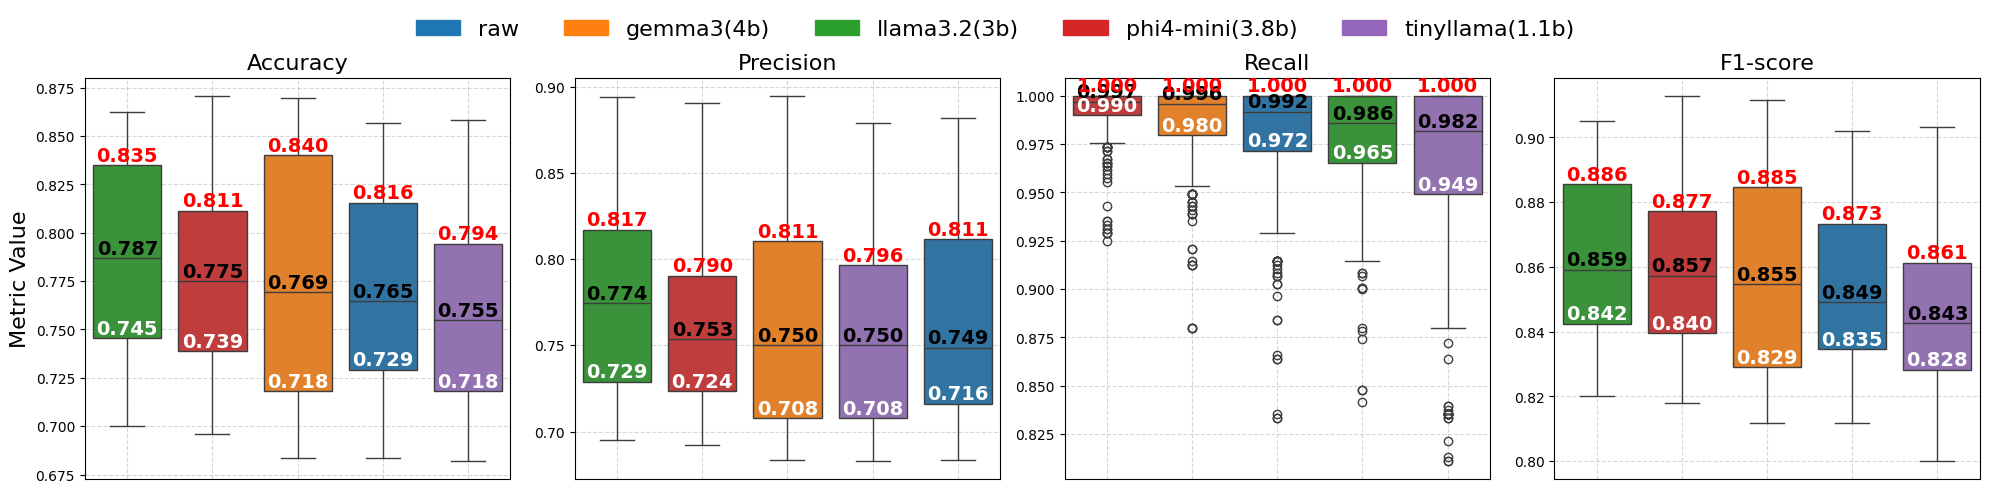

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("results/result_table.csv", sep=';', decimal=',')

# Tradução das métricas
metric_translation = {
    "accuracy": "Accuracy",
    "precision": "Precision",
    "recall": "Recall",
    "f1_score": "F1-score"
}

# Renomeação dos modelos
model_translation = {
    "gemma3_4b": "gemma3(4b)",
    "phi4-mini": "phi4-mini(3.8b)",
    "tinyllama_1.1b": "tinyllama(1.1b)",
    "llama3.2_3b": "llama3.2(3b)",
    "raw": "raw",
}
df["font"] = df["font"].replace(model_translation)

metrics = list(metric_translation.keys())

df_melt = df.melt(
    id_vars="font",
    value_vars=metrics,
    var_name="Metric",
    value_name="Value"
)

# Substituir para português
df_melt["Metric"] = df_melt["Metric"].map(metric_translation)

fonts = df["font"].unique()
palette = dict(zip(fonts, sns.color_palette("tab10", len(fonts))))

n = len(metrics)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))

for ax, m in zip(axes, metric_translation.values()):  # usa os nomes já traduzidos
    data = df_melt[df_melt["Metric"] == m]
    
    order = (
        data.groupby("font")["Value"]
        .median()
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    
    sns.boxplot(
        x="font",
        y="Value",
        hue="font",
        data=data,
        order=order,
        palette={f: palette[f] for f in order},
        dodge=False,
        legend=False,  # legenda global será adicionada no fig
        ax=ax,
    )
    
    for i, font in enumerate(order):
        subset = data[data["font"] == font]["Value"]
        median = subset.median()
        q1 = subset.quantile(0.25)
        q3 = subset.quantile(0.75)
        ax.text(i, median, f"{median:.3f}", ha='center', va='bottom',
                fontsize=14, fontweight="bold", color="black")
        ax.text(i, q1, f"{q1:.3f}", ha='center', va='bottom',
                fontsize=14, fontweight="bold", color="white")
        ax.text(i, q3, f"{q3:.3f}", ha='center', va='bottom',
                fontsize=14, fontweight="bold", color="red")
        
    ax.set_title(m, fontsize=16)
    ax.set_xlabel("")
    if ax is axes[0]:
        ax.set_ylabel("Metric Value", fontsize=16)
    else:
        ax.set_ylabel("")
    
    # remove nomes/marcas do eixo X
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax.grid(True, linestyle='--', alpha=0.5)

# --- Legenda global com cores <-> modelos ---
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[f]) for f in fonts]
fig.legend(handles, fonts, loc="upper center", ncol=len(fonts), fontsize=16, frameon=False)

# espaço extra no topo para a legenda
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


### Metrics per Ensembles

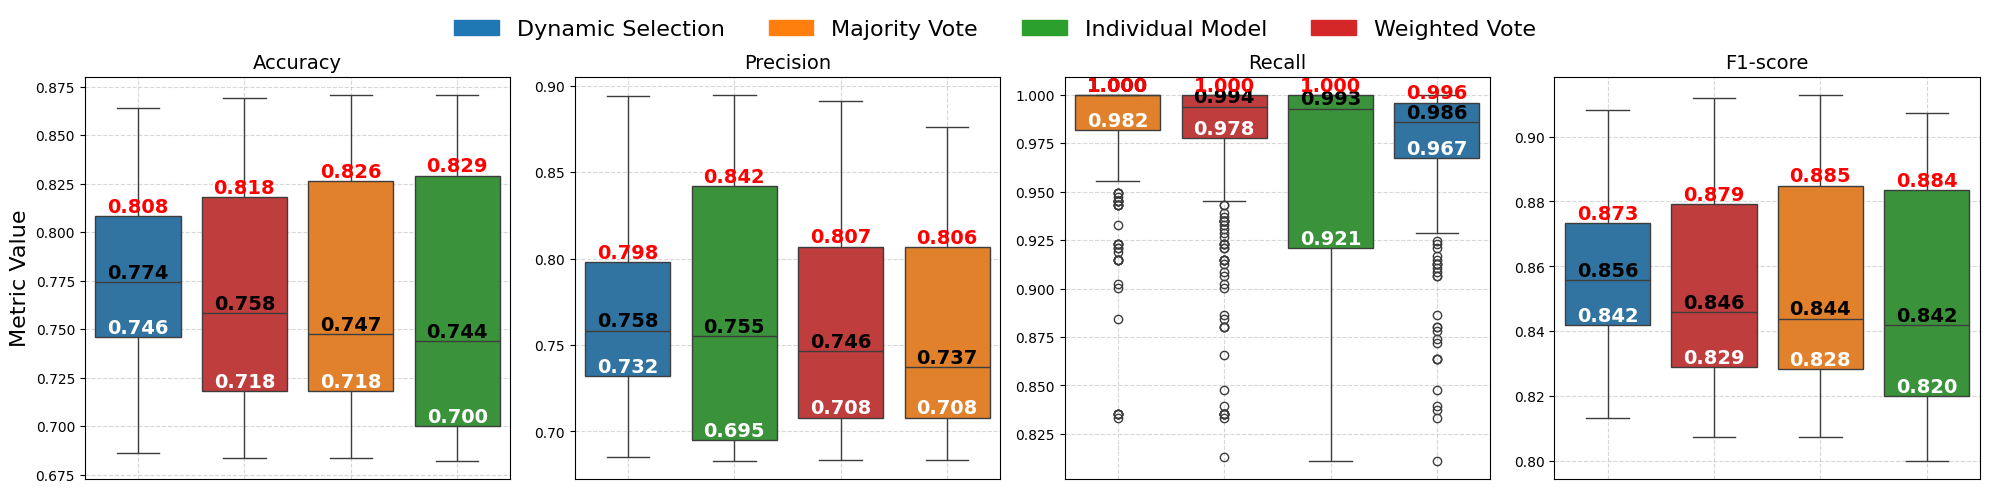

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("results/result_table.csv", sep=';', decimal=',')

metric_translation = {
    "accuracy": "Accuracy",
    "precision": "Precision",
    "recall": "Recall",      # ou "Revocação" se preferir
    "f1_score": "F1-score"   # ou "Medida-F"
}

vote_translation = {
    "dynamic_selection": "Dynamic Selection",
    "weighted_vote": "Weighted Vote",
    "majority_vote": "Majority Vote",
    "original": "Individual Model"
}

df["vote"] = df["vote"].replace(vote_translation)

metrics_en = list(metric_translation.keys())

df_melt = df.melt(
    id_vars="vote",
    value_vars=metrics_en,
    var_name="Metric",
    value_name="Value"
)

# Aplica a tradução nas métricas
df_melt["Metric"] = df_melt["Metric"].map(metric_translation)

votes = df["vote"].unique()
palette = dict(zip(votes, sns.color_palette("tab10", len(votes))))

n = len(metrics_en)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))

# Itera em paralelo pelos nomes EN e PT
for ax, (m_en, m_pt) in zip(axes, metric_translation.items()):
    data = df_melt[df_melt["Metric"] == m_pt]
    
    order = (
        data.groupby("vote")["Value"]
        .median()
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    
    sns.boxplot(
        x="vote",
        y="Value",
        hue="vote",
        data=data,
        order=order,
        palette={v: palette[v] for v in order},
        dodge=False,
        legend=False,
        ax=ax
    )

    for i, vote in enumerate(order):
        subset = data[data["vote"] == vote]["Value"]
        median = subset.median()
        q1 = subset.quantile(0.25)
        q3 = subset.quantile(0.75)
        ax.text(i, median, f"{median:.3f}", ha='center', va='bottom',
                fontsize=14, fontweight="bold", color="black")
        ax.text(i, q1, f"{q1:.3f}", ha='center', va='bottom',
                fontsize=14, fontweight="bold", color="white")
        ax.text(i, q3, f"{q3:.3f}", ha='center', va='bottom',
                fontsize=14, fontweight="bold", color="red")
        
    ax.set_title(m_pt, fontsize=14)  
    ax.set_xlabel("")
    if ax is axes[0]:
        ax.set_ylabel("Metric Value", fontsize=16)
    else:
        ax.set_ylabel("")
    
    # remove os nomes do eixo X
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax.grid(True, linestyle='--', alpha=0.5)

# adiciona legenda geral no topo
handles = [plt.Rectangle((0,0),1,1, color=palette[v]) for v in votes]
fig.legend(handles, votes, loc="upper center", ncol=len(votes), fontsize=16, frameon=False)

plt.tight_layout(rect=[0,0,1,0.92])
plt.show()


### Metrics per Models

In [84]:
df = pd.read_csv("results/result_table.csv", sep=';', decimal=',')
df.replace("deepseek-r1_14b_no_think", "deepseek-r1_14b (no_think)", inplace=True)
df.replace("deepseek-r1_14b_think", "deepseek-r1_14b (think)", inplace=True)

df.replace("qwen3_14b", "qwen3_14b (no_think)", inplace=True)
df.replace("qwen3_14b_think", "qwen3_14b (think)", inplace=True)

df.to_csv("results/result_table.csv", sep=';', decimal=',', index=False)

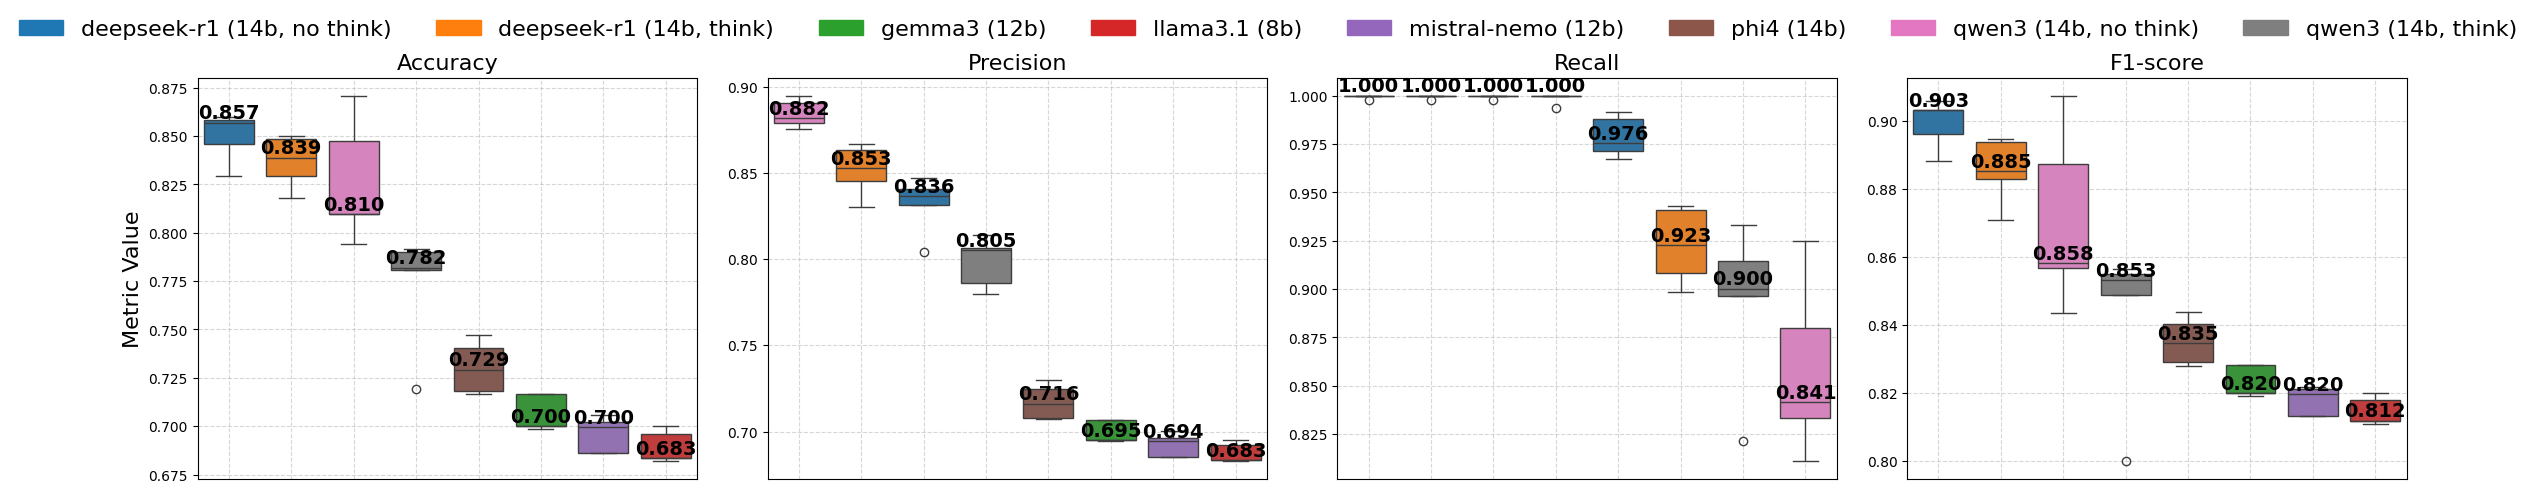

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==== Leitura e filtro (apenas modelos individuais) ====
df = pd.read_csv("results/result_table.csv", sep=';', decimal=',')
df = df[df['vote'] == 'original']  # Individual Model

# ==== Traduções de métricas ====
metric_translation = {
    "accuracy": "Accuracy",
    "precision": "Precision",
    "recall": "Recall",
    "f1_score": "F1-score",
}
metrics = list(metric_translation.keys())

# ==== Tradução / padronização dos nomes de modelos ====
model_translation = {
    "deepseek-r1_14b (no_think)": "deepseek-r1 (14b, no think)",
    "deepseek-r1_14b (think)": "deepseek-r1 (14b, think)",
    "gemma3_12b": "gemma3 (12b)",
    "llama3.1": "llama3.1 (8b)",
    "mistral-nemo": "mistral-nemo (12b)",
    "phi4": "phi4 (14b)",
    "qwen3_14b (no_think)": "qwen3 (14b, no think)",
    "qwen3_14b (think)": "qwen3 (14b, think)",
}

df["model_1"] = df["model_1"].replace(model_translation)

# ==== Derrete dataframe ====
df_melt = df.melt(
    id_vars="model_1",
    value_vars=metrics,
    var_name="Metric",
    value_name="Value"
)
df_melt["Metric"] = df_melt["Metric"].map(metric_translation)

# ==== Paleta consistente por modelo ====
models = df["model_1"].unique().tolist()
palette = dict(zip(models, sns.color_palette("tab10", len(models))))

# ==== Figura e eixos ====
n = len(metrics)
fig, axes = plt.subplots(1, n, figsize=(5.8 * n, 5))

for ax, (m_key, m_label) in zip(axes, metric_translation.items()):
    data = df_melt[df_melt["Metric"] == m_label]

    # ordena por mediana desc
    order = (
        data.groupby("model_1")["Value"]
        .median()
        .sort_values(ascending=False)
        .index
        .tolist()
    )

    sns.boxplot(
        x="model_1",
        y="Value",
        hue="model_1",
        data=data,
        order=order,
        palette={m: palette[m] for m in order},
        dodge=False,
        legend=False,
        ax=ax,
    )

    # anotações (mediana, Q1, Q3) no padrão do gráfico base
    for i, model in enumerate(order):
        subset = data[data["model_1"] == model]["Value"]
        median = subset.median()
        q1 = subset.quantile(0.25)
        q3 = subset.quantile(0.75)

        ax.text(i, median, f"{median:.3f}", ha='center', va='bottom',
                fontsize=14, fontweight="bold", color="black")

    ax.set_title(m_label, fontsize=16)
    ax.set_xlabel("")
    if ax is axes[0]:
        ax.set_ylabel("Metric Value", fontsize=16)
    else:
        ax.set_ylabel("")

    # remove labels do eixo X (como no padrão base)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax.grid(True, linestyle='--', alpha=0.5)

# ==== Legenda global no topo ====
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[m]) for m in models]
fig.legend(handles, models, loc="upper center", ncol=len(models), fontsize=16, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


### Inference Time reduce

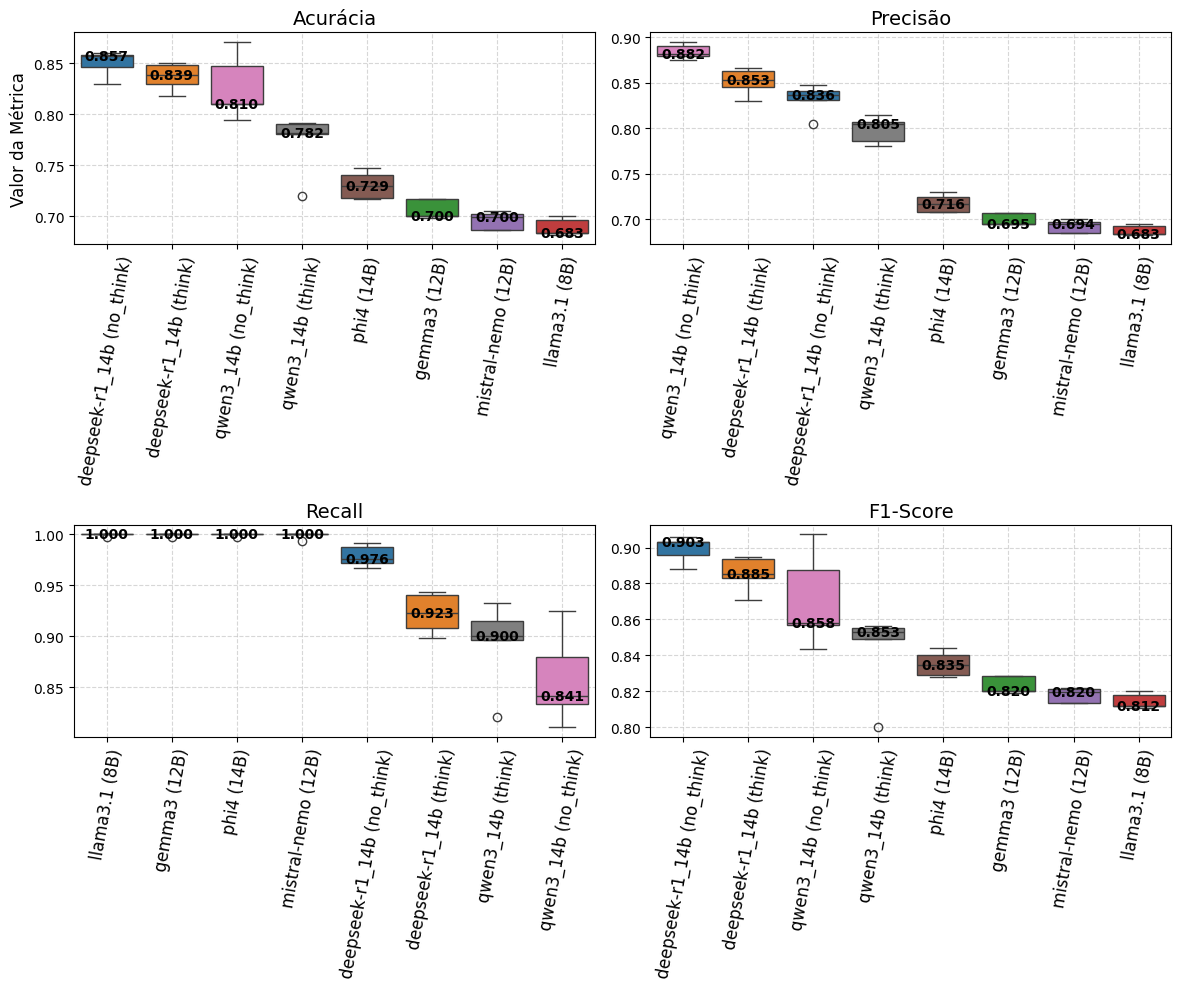

In [66]:
# figura em 2x2
n = len(metrics_en)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 com tamanho ajustado
axes = axes.flatten()  # transforma em array 1D para facilitar o loop

# itera usando os nomes PT nas abas
for ax, (m_en, m_pt) in zip(axes, metric_translation.items()):
    data = df_melt[df_melt["Metric"] == m_pt]

    order = (
        data.groupby("model_1_norm")["Value"]
        .median()
        .sort_values(ascending=False)
        .index
        .tolist()
    )

    sns.boxplot(
        x="model_1_norm",
        y="Value",
        hue="model_1_norm",
        data=data,
        order=order,
        palette={f: palette[f] for f in order},
        dodge=False,
        legend=False,
        ax=ax
    )

    # median labels
    for i, model in enumerate(order):
        subset = data[data["model_1_norm"] == model]["Value"]
        median = subset.median()
        ax.text(i, median, f"{median:.3f}", ha='center', va='center',
                fontsize=10, fontweight="bold", color="black")

    ax.set_title(m_pt, fontsize=14)          
    ax.set_xlabel("")  
    if m_en == "accuracy":  # só no primeiro eixo coloca o rótulo Y
        ax.set_ylabel("Valor da Métrica", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=80, labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### Time per Model

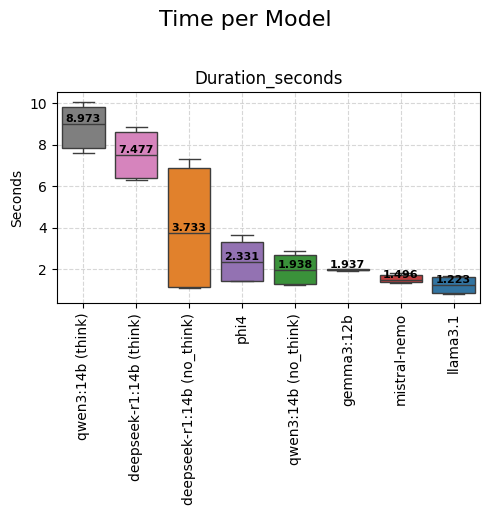

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("results/time_principal_models.csv", sep=';', decimal=',')

metrics = ["duration_seconds"]

df_melt = df.melt(
    id_vars="model",
    value_vars=metrics,
    var_name="Metric",
    value_name="Value"
)

models = df["model"].unique()
palette = dict(zip(models, sns.color_palette("tab10", len(models))))

n = len(metrics)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))

if n == 1:
    axes = [axes]

for ax, m in zip(axes, metrics):
    data = df_melt[df_melt["Metric"] == m]
    
    order = (
        data
        .groupby("model")["Value"]
        .median()
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    
    sns.boxplot(
        x="model",
        y="Value",
        hue="model",
        data=data,
        order=order,
        palette={v: palette[v] for v in order},
        dodge=False,
        legend=False,
        ax=ax
    )
    
    for i, model in enumerate(order):
        subset = data[data["model"] == model]["Value"]
        median = subset.median()
        q1 = subset.quantile(0.25)
        q3 = subset.quantile(0.75)
        
        ax.text(i, median, f"{median:.3f}", ha='center', va='bottom', fontsize=8, fontweight="bold", color="black")
        
    ax.set_title(m.capitalize())
    ax.set_xlabel("")  
    if ax is axes[0]:
        ax.set_ylabel("Seconds")
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=90)
    ax.grid(True, linestyle='--', alpha=0.5)

fig.suptitle("Time per Model", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### Time per filtering Model

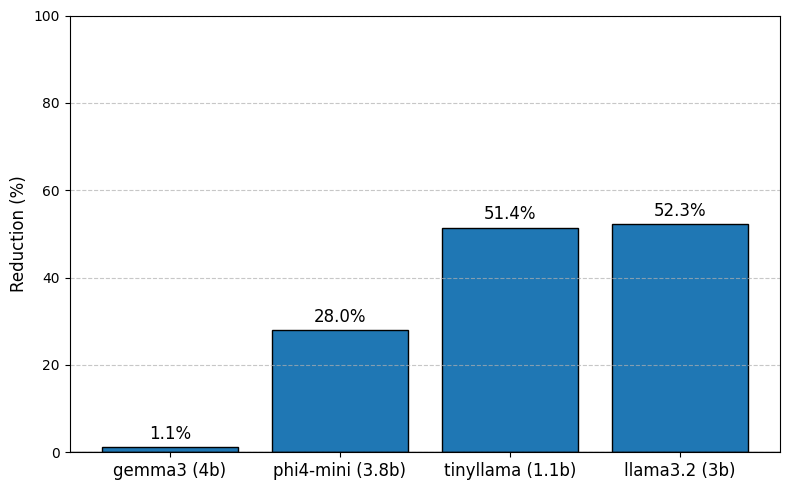

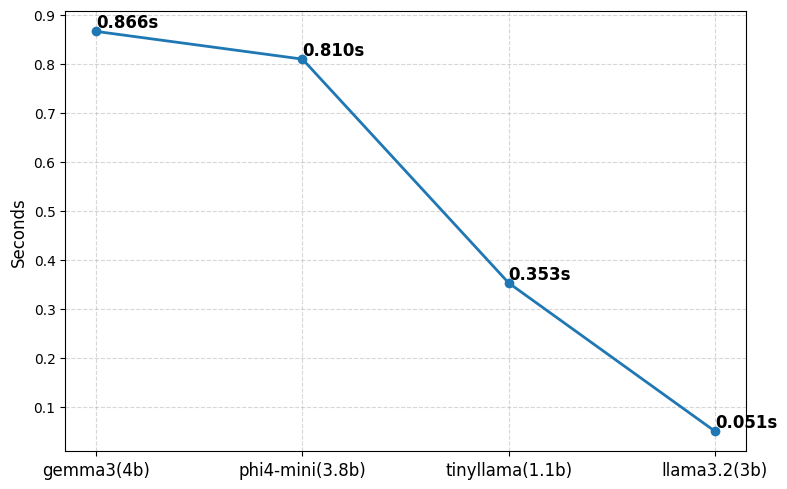

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Gráfico 1: Log Reduction (%) ----------
df_reduction = pd.read_csv("results/lines_per_model.csv", sep=';', decimal=',')

df_reduction = df_reduction.replace(
    to_replace='gemma3_4b',
    value='gemma3 (4b)',
)

df_reduction = df_reduction.replace(
    to_replace='phi4-mini',
    value='phi4-mini (3.8b)',
)

df_reduction = df_reduction.replace(
    to_replace='tinyllama_1.1b',
    value='tinyllama (1.1b)',
)

df_reduction = df_reduction.replace(
    to_replace='llama3.2_3b',
    value='llama3.2 (3b)',
)

# Calcula percentual de redução
df_reduction['reduction_%'] = (
    (df_reduction['lines_total'] - df_reduction['lines_filtering_mode'])
    / df_reduction['lines_total']
) * 100

plt.figure(figsize=(8, 5))
bars = plt.bar(df_reduction["model"], df_reduction['reduction_%'], edgecolor="black")
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("Reduction (%)", fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0, fontsize=12)

# Adiciona valores no topo das barras
for rect, val in zip(bars, df_reduction['reduction_%']):
    plt.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height() + 1,
        f"{val:.1f}%",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.tight_layout()
plt.show()

# ---------- Gráfico 2: Median Processing Time (pontos com linha) ----------
df_time = pd.read_csv("results/time_filtering_models.csv", sep=';', decimal=',')

df_time = df_time.replace(
    to_replace='gemma3:4b',
    value='gemma3(4b)',
)

df_time = df_time.replace(
    to_replace='phi4-mini',
    value='phi4-mini(3.8b)',
)

df_time = df_time.replace(
    to_replace='tinyllama:1.1b',
    value='tinyllama(1.1b)',
)

df_time = df_time.replace(
    to_replace='llama3.2:3b',
    value='llama3.2(3b)',
)

# Mediana por modelo
median_time = (
    df_time.groupby('model')['duration_seconds']
    .median()
    .sort_values(ascending=False)
)

models_order = median_time.index.tolist()
median_values = median_time.values
x = np.arange(len(models_order))

plt.figure(figsize=(8, 5))
plt.plot(x, median_values, marker='o', linewidth=2)
plt.ylabel("Seconds", fontsize=12)
plt.xlabel("")  # sem label horizontal
plt.xticks(x, models_order, rotation=0, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Anota os valores ao lado/acima de cada ponto
for xi, yi in zip(x, median_values):
    plt.text(xi, yi, f"{yi:.3f}s", ha='left', va='bottom', fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()


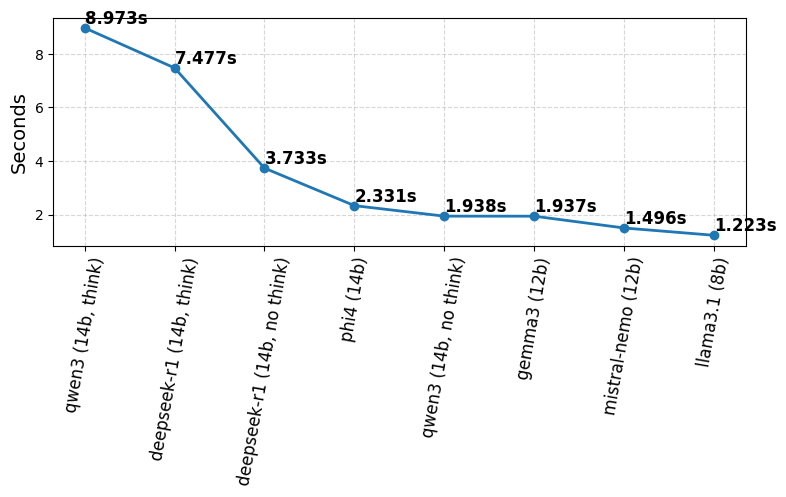

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==== Tradução / padronização dos nomes de modelos ====
model_translation = {
    "deepseek-r1:14b (no_think)": "deepseek-r1 (14b, no think)",
    "deepseek-r1:14b (think)": "deepseek-r1 (14b, think)",
    "gemma3:12b": "gemma3 (12b)",
    "llama3.1": "llama3.1 (8b)",
    "mistral-nemo": "mistral-nemo (12b)",
    "phi4": "phi4 (14b)",
    "qwen3:14b (no_think)": "qwen3 (14b, no think)",
    "qwen3:14b (think)": "qwen3 (14b, think)",
}

# ==== Leitura do CSV ====
df_time = pd.read_csv("results/time_principal_models.csv", sep=';', decimal=',')

# ==== Aplica padronização ====
df_time["model"] = df_time["model"].replace(model_translation)

# ==== Mediana por modelo ====
median_time = (
    df_time.groupby('model')["duration_seconds"]
    .median()
    .sort_values(ascending=False)
)

models_order = median_time.index.tolist()
median_values = median_time.values
x = np.arange(len(models_order))

# ==== Plot ====
plt.figure(figsize=(8, 5))
plt.plot(x, median_values, marker='o', linewidth=2)
plt.ylabel("Seconds", fontsize=14)
plt.xlabel("")  # sem label horizontal
plt.xticks(x, models_order, rotation=80, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# ==== Anota os valores ====
for xi, yi in zip(x, median_values):
    plt.text(xi, yi, f"{yi:.3f}s", ha='left', va='bottom',
             fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()
